# TabPFN-TS Prediction Visualization
This notebook visualizes predictions from TabPFN-TS on various GIFT-Eval datasets.

In [1]:
import os
from dotenv import load_dotenv
from pathlib import Path

load_dotenv()

# Configuration
dataset_storage_path = Path(os.getenv("DATASET_STORAGE_PATH"))
root_output_dir = Path.cwd() / "../output/pred_visualization"

root_output_dir.mkdir(parents=True, exist_ok=True)


In [2]:
from pathlib import Path

import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame

from gift_eval.data import Dataset
from gift_eval.dataset_definition import ALL_DATASETS
from gift_eval.tabpfn_ts_wrapper import TabPFNTSPredictor
from tabpfn_time_series.plot import plot_pred_and_actual_ts
from gift_eval.evaluate import construct_evaluation_data


def load_dataset(dataset_name, term="short", dataset_storage_path=None):
    """Load a dataset from GIFT-Eval."""
    if dataset_storage_path is None:
        dataset_storage_path = Path("../gift_eval/data")
    
    # Initialize the dataset
    # First check if we need to convert to univariate
    to_univariate = False
    temp_dataset = Dataset(
        name=dataset_name,
        term=term,
        to_univariate=False,
        storage_path=dataset_storage_path,
    )
    if temp_dataset.target_dim > 1:
        to_univariate = True
    
    # Load the actual dataset
    dataset = Dataset(
        name=dataset_name,
        term=term,
        to_univariate=to_univariate,
        storage_path=dataset_storage_path,
    )
    
    return dataset


def get_predictions(dataset, item_id=0):
    """Generate predictions for a specific item in the dataset."""
    # Initialize predictor
    tabpfn_predictor = TabPFNTSPredictor(
        ds_prediction_length=dataset.prediction_length,
        ds_freq=dataset.freq,
    )
    
    # Get train and test data for the specific item
    eval_data = dataset.test_data
    random_sample = list(eval_data)[item_id]
    
    # Generate predictions
    predictions = tabpfn_predictor.predict([random_sample[0]])

    train_tsdf = tabpfn_predictor.convert_to_timeseries_dataframe([random_sample[0]])
    test_tsdf = tabpfn_predictor.convert_to_timeseries_dataframe([random_sample[1]])
    
    return train_tsdf, test_tsdf, predictions


def convert_to_tsdf(gluonts_data, is_train=True):
    """Convert GluonTS ListDataset to TimeSeriesDataFrame."""
    all_series = []
    
    for i, entry in enumerate(gluonts_data):
        target = entry["target"]
        start_date = pd.Timestamp(entry["start"])
        _ = entry["feat_static_cat"][0] if "feat_static_cat" in entry else 0
        
        # Create date range
        dates = pd.date_range(
            start=start_date,
            periods=len(target),
            freq=pd.infer_freq(pd.date_range(start=start_date, periods=5))
        )
        
        # Create DataFrame
        series_df = pd.DataFrame({
            "timestamp": dates,
            "item_id": i,
            "target": target
        })
        series_df.set_index(["item_id", "timestamp"], inplace=True)
        all_series.append(series_df)
    
    # Combine all series
    combined_df = pd.concat(all_series)
    tsdf = TimeSeriesDataFrame(combined_df)
    
    return tsdf


def convert_forecast_to_tsdf(forecast, test_tsdf):
    """Convert GluonTS forecast to TimeSeriesDataFrame."""
    all_series = []
    
    for i, fcast in enumerate(forecast):
        # Get the item's test data to extract timestamps
        item_test = test_tsdf.loc[i]
        timestamps = item_test.index
        
        # Create DataFrame with mean prediction and quantiles
        series_data = {
            "timestamp": timestamps,
            "item_id": i,
            "target": fcast.mean
        }
        
        # Add quantiles
        for q in [0.1, 0.5, 0.9]:
            q_str = str(q)
            series_data[q_str] = fcast.quantile(q)
        
        series_df = pd.DataFrame(series_data)
        series_df.set_index(["item_id", "timestamp"], inplace=True)
        all_series.append(series_df)
    
    # Combine all series
    combined_df = pd.concat(all_series)
    pred_tsdf = TimeSeriesDataFrame(combined_df)
    
    return pred_tsdf


def visualize_dataset(dataset_name, term="short", item_id=0):
    print(f"\n## Dataset: {dataset_name} (term: {term})")
    
    # Use construct_evaluation_data to get dataset
    sub_datasets = construct_evaluation_data(
        dataset_name=dataset_name,
        dataset_storage_path=dataset_storage_path,
        terms=[term]
    )
    
    if not sub_datasets:
        print(f"No datasets found for {dataset_name} with term {term}")
        return
    
    # Get the first dataset that matches the term
    dataset, dataset_metadata = sub_datasets[0]
    
    print(f"Prediction length: {dataset.prediction_length}")
    print(f"Frequency: {dataset.freq}")
    print(f"Target dimension: {dataset.target_dim}")
    print(f"Dataset full name: {dataset_metadata['full_name']}")
    
    # Generate predictions
    train_tsdf, test_tsdf, predictions = get_predictions(dataset, item_id)
    
    # Convert to TimeSeriesDataFrame
    pred_tsdf = convert_forecast_to_tsdf(predictions, test_tsdf)
    
    # Visualize ground truth and predictions in the same plot
    print("\nGround truth and predictions:")
    output_dir = root_output_dir / term
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_pred_and_actual_ts(pred_tsdf, train_tsdf, test_tsdf, item_ids=[item_id], show_points=True,
                            hide_legend=True,
                            title=f"{dataset_name}/{term}",
                            save_path=output_dir / f"{dataset_name.replace('/', '-')}-{term}.pdf")


def visualize_multiple_items(dataset_name, term="short", item_ids=[0, 1, 2]):
    print(f"\n## Dataset: {dataset_name} (term: {term})")
    
    # Load dataset
    try:
        dataset = load_dataset(dataset_name, term, dataset_storage_path)
        print(f"Prediction length: {dataset.prediction_length}")
        print(f"Frequency: {dataset.freq}")
        print(f"Target dimension: {dataset.target_dim}")
        print(f"Number of time series: {len(dataset.train_data)}")
        
        # Generate predictions
        train_data, test_data, predictions = get_predictions(dataset)
        
        # Convert to TimeSeriesDataFrame
        train_tsdf = convert_to_tsdf(train_data, is_train=True)
        test_tsdf = convert_to_tsdf(test_data, is_train=False)
        pred_tsdf = convert_forecast_to_tsdf(predictions, test_tsdf)
        
        # Visualize multiple items
        valid_item_ids = [i for i in item_ids if i < len(train_data)]
        if not valid_item_ids:
            print(f"No valid item IDs found. Max item ID is {len(train_data)-1}")
            return False
        
        print("\nGround truth and predictions for multiple items:")
        plot_pred_and_actual_ts(pred_tsdf, train_tsdf, test_tsdf, item_ids=valid_item_ids, show_points=True)
        
        return True
    except Exception as e:
        print(f"Error visualizing {dataset_name}: {str(e)}")
        return False


## Available Datasets
Let's see what datasets are available in GIFT-Eval.

In [3]:
# Print available datasets
print(f"Available datasets: {len(ALL_DATASETS)}")
for i, dataset in enumerate(ALL_DATASETS):
    print(f"{i+1}. {dataset}")

Available datasets: 55
1. ett2/W
2. us_births/M
3. us_births/D
4. ett2/D
5. bitbrains_fast_storage/H
6. hospital
7. m4_weekly
8. m4_hourly
9. SZ_TAXI/H
10. car_parts_with_missing
11. bizitobs_l2c/5T
12. restaurant
13. electricity/H
14. solar/D
15. saugeenday/M
16. jena_weather/H
17. jena_weather/D
18. m4_yearly
19. saugeenday/D
20. LOOP_SEATTLE/D
21. solar/W
22. bitbrains_rnd/H
23. ett1/15T
24. bizitobs_service
25. saugeenday/W
26. hierarchical_sales/W
27. M_DENSE/H
28. bizitobs_application
29. m4_quarterly
30. ett1/H
31. electricity/W
32. solar/10T
33. SZ_TAXI/15T
34. bizitobs_l2c/H
35. electricity/15T
36. bitbrains_fast_storage/5T
37. solar/H
38. electricity/D
39. LOOP_SEATTLE/5T
40. ett2/H
41. M_DENSE/D
42. covid_deaths
43. temperature_rain_with_missing
44. LOOP_SEATTLE/H
45. ett2/15T
46. kdd_cup_2018_with_missing/H
47. bitbrains_rnd/5T
48. m4_daily
49. us_births/W
50. ett1/D
51. jena_weather/10T
52. kdd_cup_2018_with_missing/D
53. hierarchical_sales/D
54. m4_monthly
55. ett1/W


In [4]:
HUGE_DATASETS = [
    "bitbrains_rnd/5T",
    "bitbrains_fast_storage/5T",
    "electricity/15T",
    "LOOP_SEATTLE/5T",
    "LOOP_SEATTLE/H",
    "temperature_rain_with_missing",
]

## Visualization


## Dataset: solar/W (term: short)
Prediction length: 8
Frequency: W-FRI
Target dimension: 1
Dataset full name: solar/W/short


/home/liam_priorlabs_ai/tabpfn-time-series/tabpfn_time_series/features/feature_transformer.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tsdf = pd.concat([train_tsdf, test_tsdf])


  Welcome Back! Found existing access token, reusing it for authentication.


Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 288.45it/s]


  Welcome Back! Found existing access token, reusing it for authentication.


Processing: 100%|██████████| [00:01<00:00]



Ground truth and predictions:


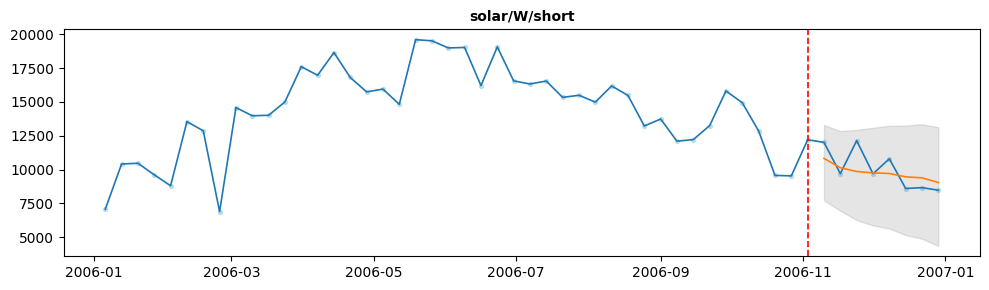

In [5]:
visualize_dataset("solar/W", term="short")